<a href="https://colab.research.google.com/github/nonoumasy/Los-Angeles-Crime-2020/blob/master/Los_Angeles_Crime_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

Data Source: https://data.lacity.org/A-Safe-City/Crime-Data-from-2020-to-Present/2nrs-mtv8

In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import re
import folium
from pandas import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import plotly as py
import seaborn as sns

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#clean and prepare the data 

def clean_this(file_to_clean):
    '''
    cleans the file
    '''
    #load data into chunks since its a BIG file and then concat it back
    df = pd.read_csv(file_to_clean)
    
    #keep only relevant columns
    df = df[['DATE OCC','TIME OCC','AREA NAME', 'Crm Cd', 'Crm Cd Desc','Mocodes', 
             'Vict Age', 'Vict Sex','Vict Descent','Premis Desc','Weapon Desc',
             'Status Desc', 'LOCATION', 'LAT', 'LON']]
    
    #column cleanup
    df.columns = df.columns.str.lower().str.replace('\W+', '_').str.replace('(', '').str.replace(')', '')
    
    #change some columns to category type
    for col in df.select_dtypes(['object']):   
        df[col] = df[col].astype('category')
    
    #cleanup and process datatime data
    df.time_occ = df.time_occ.astype(str)
    df.time_occ = df.time_occ.str.zfill(4)
    df.time_occ = df.time_occ.str.ljust(6, fillchar='0')
    df.time_occ = df.time_occ.str.slice(0,2) + ':' + df.time_occ.str.slice(2,4) + ":" + df.time_occ.str.slice(4,6)
    
    #combine date and time and convert to datetime series
    df['date_occ'] = df['date_occ'].str.split(' ').str[0]
    df['date_time'] = df.date_occ + df.time_occ
    df.date_time = pd.to_datetime(df.date_time, format='%m/%d/%Y%H:%M:%S')
    
    #set date_time as index
    df.set_index('date_time', inplace=True)
    
    ## Create a violent crimes column. This is based on UCR Reporting pdf
    violent_crime_code = [110, 113, 121, 122, 815, 821, 210, 220, 230, 231, 236, 250, 251, 926, \
                      435, 436, 437, 622, 623, 624, 625, 626, 647, 763, 928, 930]
    df['violent_crime'] = df.crm_cd.isin(violent_crime_code).astype(int)

    #cleans up whitespaces on address
    df.location = df.location.str.lstrip().str.rstrip().str.strip()
    df.location = (df['location'].str.split()).str.join(' ')
    
    #replace race names using map
    race_dict = {'A' : 'Other Asian',
            'B' : 'Black', 
            'C' : 'Chinese', 
            'D' : 'Cambodian', 
            'F' : 'Filipino', 
            'G' : 'Guamanian', 
            'H' : 'Hispanic/Latin',
            'I' : 'AmerIndian/Alaskan',
            'J' : 'Japanese', 
            'K' : 'Korean', 
            'L' : 'Laotian', 
            'O' : 'Other', 
            'P' : 'Pacific Islander ',
            'S' : 'Samoan', 
            'U' : 'Hawaiian',
            'V' : 'Vietnamese', 
            'W' : 'White', 
            'X' : 'Unknown', 
            'Z' : 'Asian Indian'}

    df['vict_descent'] = df['vict_descent'].map(race_dict)
    
    #find age outliers and normalized
    for val in range(int(86.0),int(119.0)):
        df.vict_age.replace(val, np.nan, inplace=True)
    
    df.vict_age.replace(0.0, np.nan, inplace=True)
    
    #drop unnecessary columns
    df.drop(['date_occ', 'time_occ'], axis=1, inplace=True)
    
    return df

In [3]:
df = clean_this('https://data.lacity.org/api/views/2nrs-mtv8/rows.csv?accessType=DOWNLOAD')

In [4]:
# last 3 months
last_3m_df = df[df.index > '2020-04-11']

In [5]:
# last 3 months top 5 crimes
last_3m_df.crm_cd_desc.value_counts(normalize=True, ascending=False)[:5]

VEHICLE - STOLEN                                           0.119533
BATTERY - SIMPLE ASSAULT                                   0.083957
BURGLARY                                                   0.074683
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)    0.070482
BURGLARY FROM VEHICLE                                      0.064381
Name: crm_cd_desc, dtype: float64

In [6]:
# create a new dataframe of only violent crimes
violent_df = df[df.violent_crime == 1]

In [7]:
violent_df.head()

,area_name,crm_cd,crm_cd_desc,mocodes,vict_age,vict_sex,vict_descent,premis_desc,weapon_desc,status_desc,location,lat,lon,violent_crime
date_time,,,,,,,,,,,,,,
2020-01-08 22:30:00,Southwest,624,BATTERY - SIMPLE ASSAULT,0444 0913,36.0,F,Black,SINGLE FAMILY DWELLING,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Adult Other,1100 W 39TH PL,34.0141,-118.2978,1
2020-01-01 03:30:00,Central,624,BATTERY - SIMPLE ASSAULT,0416 1822 1414,25.0,M,Hispanic/Latin,SIDEWALK,UNKNOWN WEAPON/OTHER WEAPON,Invest Cont,700 S HILL ST,34.0459,-118.2545,1
2020-01-01 05:10:00,Central,626,INTIMATE PARTNER - SIMPLE ASSAULT,1414 1218 2000 1814 0416 0447,53.0,F,Black,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)","STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Invest Cont,300 E 5TH ST,34.0449,-118.2458,1
2020-01-01 00:30:00,Central,121,"RAPE, FORCIBLE",0413 1822 1262 1415,25.0,F,Hispanic/Latin,NIGHT CLUB (OPEN EVENINGS ONLY),UNKNOWN WEAPON/OTHER WEAPON,Invest Cont,700 S BROADWAY,34.0452,-118.2534,1
2020-01-05 09:55:00,Central,930,CRIMINAL THREATS - NO WEAPON DISPLAYED,0421 0906,35.0,M,Other,PARKING LOT,VERBAL THREAT,Invest Cont,800 N ALAMEDA ST,34.0615,-118.2412,1


# Pandas Profiling

In [8]:
#ProfileReport(df)

# Exploratory Data Analysis (EDA)

For analyzing crime data

Target Profile Analysis, also known as vict profile analysis, is an attempt to identify the type of person, structure, vehicle or establishment most likely to be attacked by a suspect. 


The task of analyzing data and drawing conclusions from them is, much like putting a jig·saw puzzle together. The analyst is working with many data elements that have been gathered from a wide variety of sources. The goal is to combine the data so that a true "picture" of criminal activity can be determined. These pictures manifest themselves in the form of crime patterns. As described below, they are of two types: 

Geographic concentration patterns refer to patterns identified on the basis of: 
• similarity of crime type (e.g., commercial burglary),• multiple occurrences in well-defined geographic areas. 

Specific and recurring MO patterns refer to patterns identified on the basis of: 
• similarity of suspect and/or suspect vehicle descrip.. tion(s) 
• unique MO characteristics. 


In [9]:
df.describe()

,crm_cd,vict_age,lat,lon,violent_crime
count,99362.000000,74976.000000,99362.000000,99362.000000,99362.000000
mean,511.121193,39.418334,33.781919,-117.337161,0.296321
std,209.484437,15.237367,3.147446,10.925739,0.456636
min,110.000000,2.000000,0.000000,-118.667300,0.000000
25%,330.000000,28.000000,34.009900,-118.430575,0.000000
50%,510.000000,37.000000,34.058800,-118.320400,0.000000
75%,626.000000,50.000000,34.167900,-118.273900,1.000000
max,956.000000,120.000000,34.329300,0.000000,1.000000


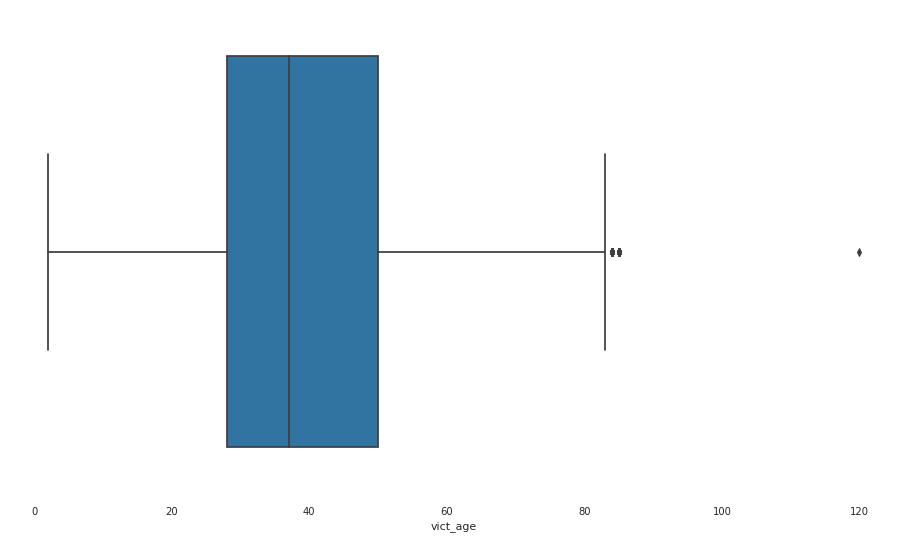

In [10]:
plt.figure(figsize=(16,9))
sns.boxplot(x=df.vict_age)

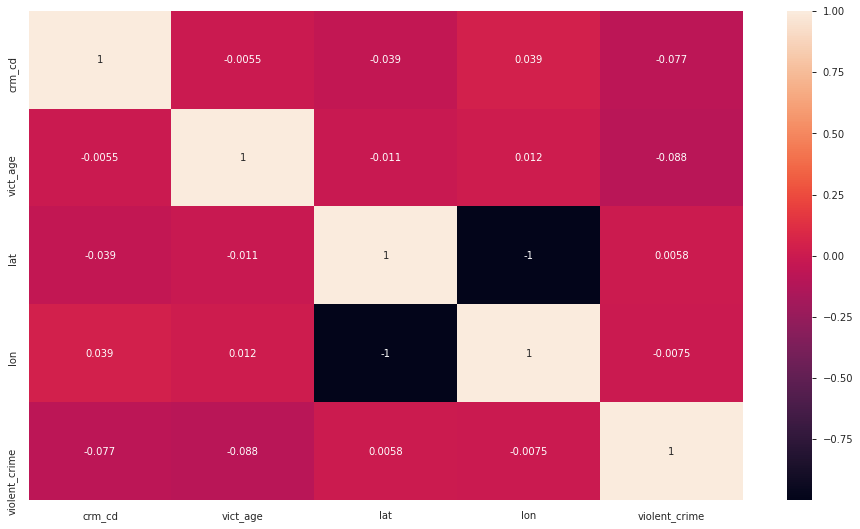

In [11]:
#correlation between the data
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(), annot=True)

In [12]:
#what type of crime is most prevalent?
df.crm_cd_desc.value_counts(dropna=True)[:5]

VEHICLE - STOLEN                                           10060
BATTERY - SIMPLE ASSAULT                                    8408
BURGLARY FROM VEHICLE                                       6994
BURGLARY                                                    6660
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)     6530
Name: crm_cd_desc, dtype: int64

In [13]:
#what type of crime is least prevalent?
df.crm_cd_desc.value_counts()[-5:]

THEFT, COIN MACHINE - ATTEMPT               1
TILL TAP - GRAND THEFT ($950.01 & OVER)     1
GRAND THEFT / AUTO REPAIR                   1
PICKPOCKET, ATTEMPT                         1
FIREARMS RESTRAINING ORDER (FIREARMS RO)    1
Name: crm_cd_desc, dtype: int64

In [14]:
#where was there most crime?
df.area_name.value_counts()[:5]

77th Street    6463
Central        5910
Southwest      5597
Southeast      5447
Pacific        5255
Name: area_name, dtype: int64

In [15]:
#where was there least crime?
df.area_name.value_counts()[-5:]

Topanga        4201
West Valley    4073
Hollenbeck     3959
Devonshire     3909
Foothill       3666
Name: area_name, dtype: int64

In [16]:
#Where did most murders occured?
df[df.crm_cd_desc == 'CRIMINAL HOMICIDE'].area_name.value_counts()[:5]

77th Street    23
Newton         15
Southeast      13
Central        10
Hollenbeck     10
Name: area_name, dtype: int64

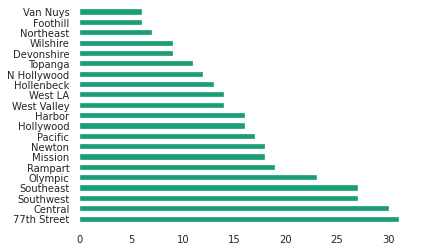

In [17]:
#Where did most Rapes occured?
df[df.crm_cd_desc == 'RAPE, FORCIBLE'].area_name.value_counts().plot(kind='barh', cmap='Dark2')

In [18]:
#Where did most robbery occured?
df[df.crm_cd_desc == 'ROBBERY'].area_name.value_counts()

77th Street    416
Southeast      358
Newton         275
Southwest      265
Central        237
Rampart        236
Olympic        189
Hollywood      171
Wilshire       135
Mission        128
Pacific        127
Harbor         120
Topanga        112
N Hollywood    111
Hollenbeck     110
Northeast      107
West Valley    105
Van Nuys        96
Foothill        90
Devonshire      85
West LA         70
Name: area_name, dtype: int64

In [19]:
#Crime by year
print('Crime by year')
print(df.index.year.value_counts())
print()

Crime by year
2020    99362
Name: date_time, dtype: int64



In [20]:
#Crime by day of week
print('Crime by day of week')
print(df.index.dayofweek.value_counts().sort_index())
print()

Crime by day of week
0    14062
1    13381
2    14263
3    13959
4    15301
5    14628
6    13768
Name: date_time, dtype: int64



In [21]:
#Crime by day of hour
print('Crime by hour')
print(df.index.hour.value_counts()[:5])
print()

Crime by hour
12    6308
18    6241
17    6159
20    5764
19    5695
Name: date_time, dtype: int64



In [22]:
# Top 5 crimes against women
print('Main Crime type against women')
print(df[df['vict_sex'] == 'F' ].crm_cd_desc.value_counts()[:5])
print()

Main Crime type against women
INTIMATE PARTNER - SIMPLE ASSAULT                          4124
BATTERY - SIMPLE ASSAULT                                   4007
BURGLARY FROM VEHICLE                                      2915
THEFT PLAIN - PETTY ($950 & UNDER)                         2298
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)    2144
Name: crm_cd_desc, dtype: int64



In [23]:
# Top 5 crimes against men
print('Main Crime type against men')
print(df[df['vict_sex'] == 'M' ].crm_cd_desc.value_counts()[:5])
print()

Main Crime type against men
BATTERY - SIMPLE ASSAULT                                   4364
BURGLARY FROM VEHICLE                                      3934
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT             3802
BURGLARY                                                   3434
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)    3108
Name: crm_cd_desc, dtype: int64



In [24]:
# Murder victs by gender
df[df['crm_cd_desc'] == 'CRIMINAL HOMICIDE' ].vict_sex.value_counts()[:5]

M    125
F     20
X      0
H      0
Name: vict_sex, dtype: int64

In [25]:
# Murder victs by gender
df[df['crm_cd_desc'] == 'CRIMINAL HOMICIDE' ].vict_descent.value_counts()[:5]

Hispanic/Latin    69
Black             54
White             11
Other              8
Other Asian        2
Name: vict_descent, dtype: int64

In [26]:
df[df['crm_cd_desc'] == 'CRIMINAL HOMICIDE' ].vict_age.value_counts().head()

26.0    6
45.0    5
37.0    5
27.0    5
24.0    5
Name: vict_age, dtype: int64

In [27]:
# Murder victs by age
df[df['crm_cd_desc'] == 'CRIMINAL HOMICIDE' ].premis_desc.value_counts()[:5]

STREET                                          47
SIDEWALK                                        20
SINGLE FAMILY DWELLING                          16
MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)    14
PARKING LOT                                     12
Name: premis_desc, dtype: int64

In [28]:
#pivot table
df.pivot_table(index='vict_descent',
               columns='vict_sex',
               values='vict_age',
               aggfunc='sum',
              fill_value=0)

vict_sex,F,H,M,X
vict_descent,,,,
Other Asian,45382,37,49256,0
Black,285671,84,250059,125
Chinese,2822,0,3597,0
Cambodian,0,0,52,0
Filipino,3448,107,4100,25
Guamanian,154,0,199,0
Hispanic/Latin,534872,163,592265,348
AmerIndian/Alaskan,678,0,947,0
Japanese,1955,0,1648,0


In [29]:
# Murder victs by gender
df[df['crm_cd_desc'] == 'RAPE, FORCIBLE' ].area_name.value_counts()[:5]

77th Street    31
Central        30
Southwest      27
Southeast      27
Olympic        23
Name: area_name, dtype: int64

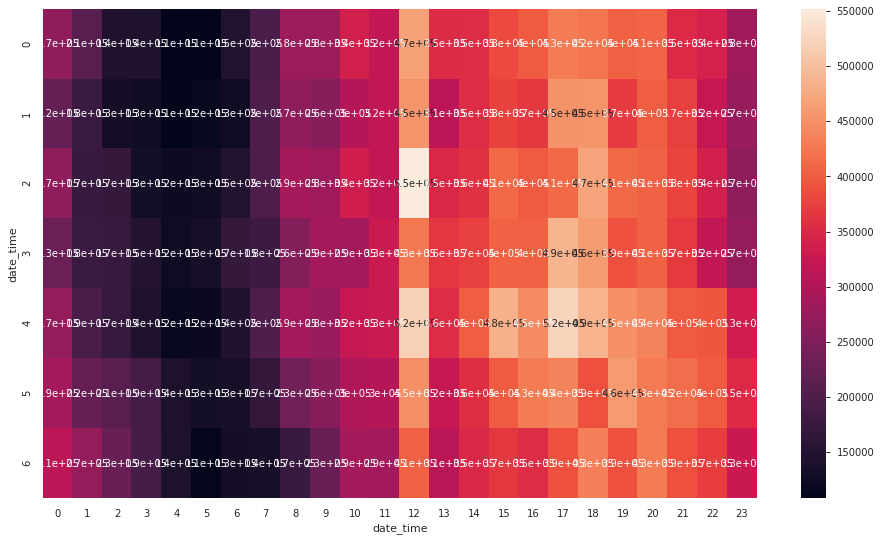

In [30]:
#plot of serious crimes -  hour vs. day_of_week
data = df.groupby([df.index.dayofweek, df.index.hour]).crm_cd.sum().unstack()
plt.figure(figsize=(16,9))         # Sample figsize in inches
sns.heatmap(data, annot=True)

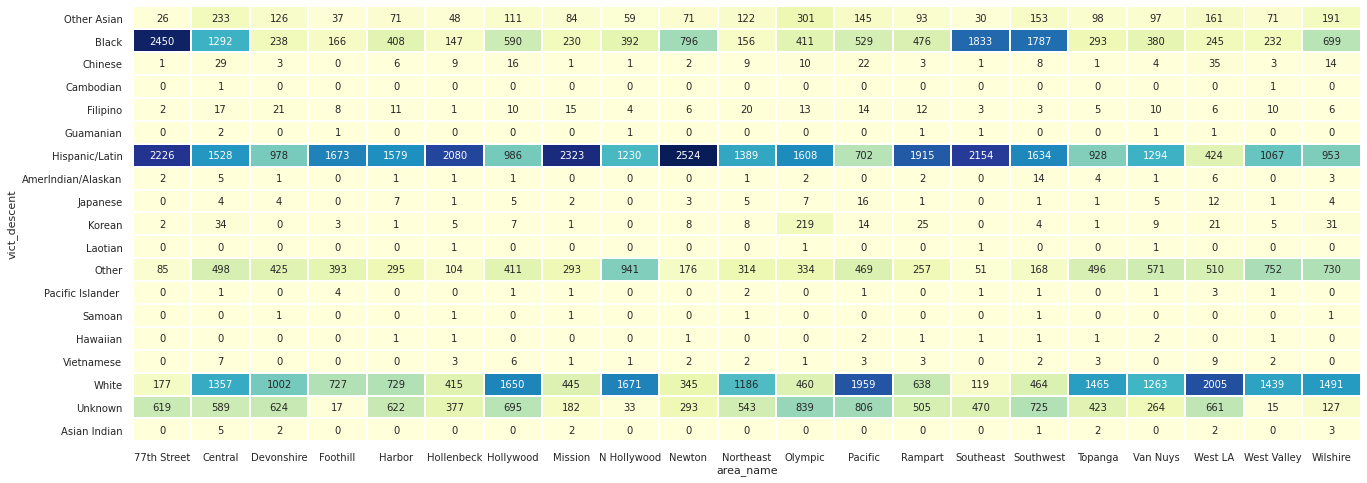

In [31]:
cross_tab = pd.crosstab(df.vict_descent, df.area_name)
fig, ax = plt.subplots(figsize=(22,8))         # Sample figsize in inches
sns.heatmap(cross_tab,
            cmap="YlGnBu",
            annot=True,
            fmt="d",
            linewidths=1,
            cbar=False,
            ax=ax)

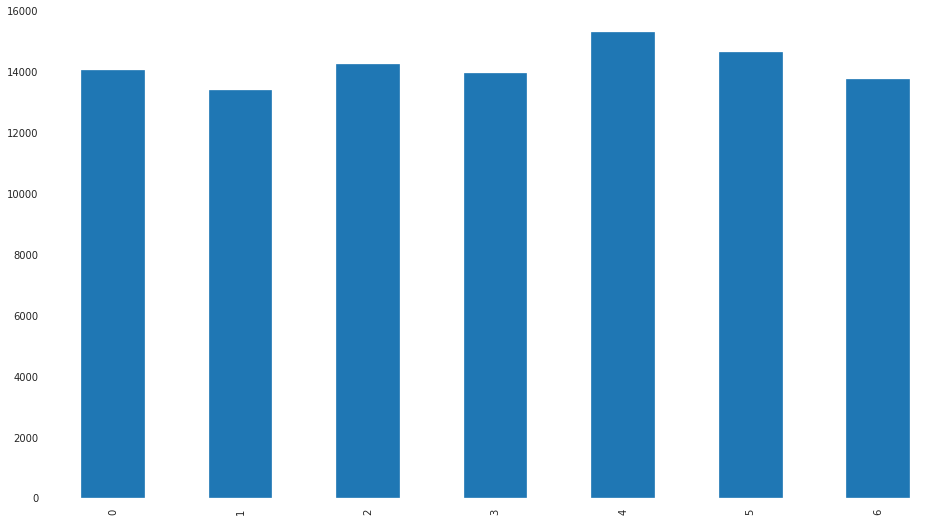

In [32]:
#When did most crimes occured in terms of days of the week?
plt.figure(figsize=(16,9))
df.index.dayofweek.value_counts().sort_index().plot(kind='bar')

In [33]:
#victs by gender
print(df.vict_sex.value_counts())
print()

#victs by race
print(df.vict_descent.value_counts())
print()

#victs by age
print('victs by avg age')
df.vict_age= df.vict_age.abs()
print(df.vict_age.mean())
print()


M    42689
F    35839
X     8452
H       11
Name: vict_sex, dtype: int64

Hispanic/Latin        31195
White                 21007
Black                 13750
Unknown                9429
Other                  8273
Other Asian            2328
Korean                  398
Filipino                197
Chinese                 178
Japanese                 79
Vietnamese               45
AmerIndian/Alaskan       44
Pacific Islander         17
Asian Indian             17
Hawaiian                 12
Guamanian                 8
Samoan                    6
Laotian                   4
Cambodian                 2
Name: vict_descent, dtype: int64

victs by avg age
39.418333866837386



In [34]:
#victs by gender and crime
print('Main crime incidents on Women')
print(df[df['vict_sex'] == 'F'].crm_cd_desc.value_counts()[:5])
print()
print('Main crime incidents on Men')
print(df[df['vict_sex'] == 'M'].crm_cd_desc.value_counts()[:5])
print()



Main crime incidents on Women
INTIMATE PARTNER - SIMPLE ASSAULT                          4124
BATTERY - SIMPLE ASSAULT                                   4007
BURGLARY FROM VEHICLE                                      2915
THEFT PLAIN - PETTY ($950 & UNDER)                         2298
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)    2144
Name: crm_cd_desc, dtype: int64

Main crime incidents on Men
BATTERY - SIMPLE ASSAULT                                   4364
BURGLARY FROM VEHICLE                                      3934
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT             3802
BURGLARY                                                   3434
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)    3108
Name: crm_cd_desc, dtype: int64



In [36]:
print('Main crime incidents on victs over 60 years old')
df[(df['vict_age'] < 60)].crm_cd_desc.value_counts()[:5]


Main crime incidents on victs over 60 years old


BATTERY - SIMPLE ASSAULT                                   7092
BURGLARY FROM VEHICLE                                      6184
INTIMATE PARTNER - SIMPLE ASSAULT                          5340
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT             4684
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)    4239
Name: crm_cd_desc, dtype: int64

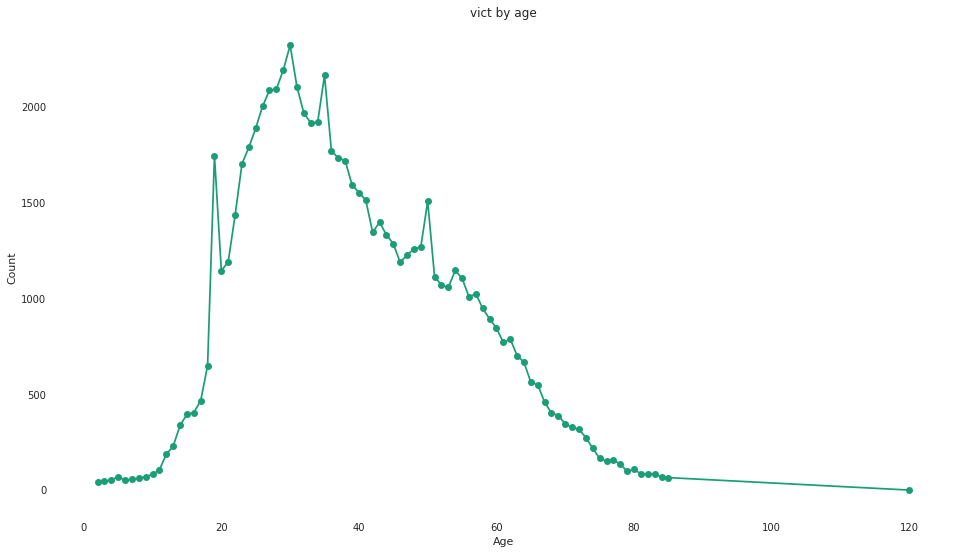

In [42]:
#vict by age
df.vict_age.value_counts().sort_index().plot(figsize=(16,9),marker='o', colormap='Dark2')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('vict by age')
plt.show()

In [44]:
plot = px.histogram(violent_df,
                    x='area_name',
                    color='area_name',
                    animation_frame= violent_df.index.year,
                    title='LA Violent Crimes 2020',
                   )

plot.layout.showlegend = False
plot.show()

# Time Series Analysis

The findings from an analysis I did for LA Crime 2010-2019 show that all major crime rates exhibit seasonal behavior, and that most follow similar cycles. The existence of seasonal patterns is not explainable by monthly temperature differences between areas, but seasonality and temperature variations do interact with each other. These findings imply that seasonal fluctuations have both environmental and social components, which can combine to create different patterns from one location to another(see reference 3).




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.


yhat           853.059268
yhat_lower     587.402489
yhat_upper    1118.526158
dtype: float64


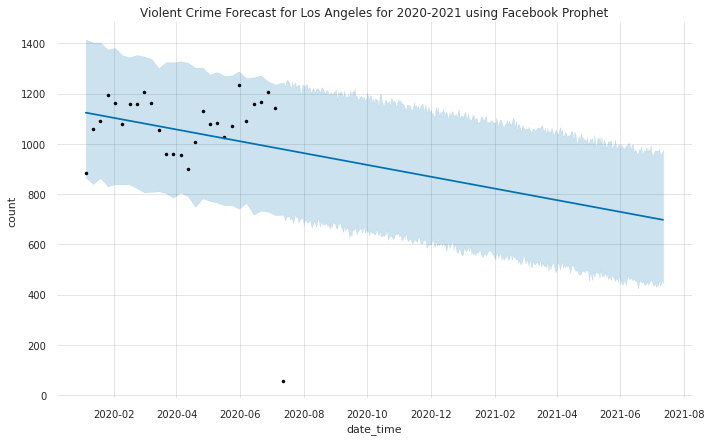

In [45]:
import pandas as pd
from fbprophet import Prophet

violent_df['date_time'] = violent_df.index

# preprocess for forecasting
forecast_df = violent_df[['date_time', 'violent_crime']]
forecast_df.columns = ['ds', 'y']
forecast_df.set_index('ds', drop=True, inplace=True)
forecast_df = forecast_df.resample('W').sum()
forecast_df.reset_index(inplace=True)


m = Prophet()
m.fit(forecast_df)
future = m.make_future_dataframe(periods=365)

forecast = m.predict(future)
fig1 = m.plot(forecast)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].mean())

plt.xlabel('date_time')
plt.ylabel('count')
plt.title('Violent Crime Forecast for Los Angeles for 2020-2021 using Facebook Prophet');

# Geospatial Analysis


In [46]:
#dualmap of crime in LA

from folium.plugins import FastMarkerCluster
from folium.plugins import HeatMap

m = folium.Map(
    location=[34.127141, -118.29008],
    zoom_start=8,
    min_zoom=10,
    tiles='cartodbpositron',

)

folium.plugins.Fullscreen(position='bottomright').add_to(m)


HeatMap(violent_df[['lat', 'lon']].values.tolist(), radius=10, name=2019).add_to(m)


m.save('map.html')
m

# Data Source


1.  Dataset : https://data.lacity.org/A-Safe-City/Crime-Data-from-2020-to-Present/2nrs-mtv8
2.  MO Code : https://data.lacity.org/api/views/63jg-8b9z/files/3db69cd3-446c-4dcd-82eb-3436dc08d3be?download=true&filename=MO_CODES_Numerical_20180627.pdf
3. https://data.lacity.org/api/views/63jg-8b9z/files/131cdc45-bfbc-433f-b370-deeb3efeb5ff?download=true&filename=ucr_handbook_2013.pdf
4. https://data.lacity.org/api/views/63jg-8b9z/files/fff2caac-94b0-4ae5-9ca5-d235b19e3c44?download=true&filename=UCR-COMPSTAT062618.pdf




# References:
1. LAPD Crime 
    http://www.lapdonline.org/inside_the_lapd/content_basic_view/27333
    
2. Crime Classification Grouping:
    https://www.nap.edu/read/23492/chapter/7#128

3. Seasonal Cycles in Crime, and Their Variability, https://www.jstor.org/stable/43551937?seq=1
4. Seasonal Patterns in Criminal victization Trends, https://www.bjs.gov/content/pub/pdf/spcvt.pdf
5. IS CRIME SEASONAL? , https://bjs.gov/content/pub/pdf/ics.pdf
